In [ ]:
# 서울시 홈페이지
# 서울소식 버튼 클릭
# 게시글을 크롤링
# 1페이지 ~ 5페이지
# 각각의 페이지 내 게시글 제목 & 게시글 클릭 이동 페이지 URL
# URL 이동 후 게시글을 업로드한 부서 & 게시날짜
# 어느 부서가 가장 많은 게시물을 업로드했는지 (시각화)
# 어느 날짜에 게시물들이 많이 업로드되었는지 (시각화)

In [8]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from webdriver_manager.chrome import ChromeDriverManager

import time
import pandas as pd
from urllib.parse import urljoin

service = Service(ChromeDriverManager().install())
options = Options()
# options.add_argument("--headless")
# options.add_argument("--disable-gpu")
options.add_argument("--disable-dev-shm-usage")
options.add_argument("--window-size=1920x1080")
options.add_argument("--start-maximized")
options.add_argument("--user-agent=Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/26.2 Safari/605.1.15")
options.add_argument("--lang=ko_KR")

driver = webdriver.Chrome(service=service, options=options)
wait = WebDriverWait(driver, 10)

# 목록 제목 & 링크값을 수집하는 함수 선언
def collect_list_links_on_current_page() :
    base = driver.current_url # https://www.seoul.go.kr/realmnews/in/list.do
    items = driver.find_elements(By.CSS_SELECTOR, "div.news-lst div.item > a")

    links = []
    for item in items :
        title = item.find_element(By.CSS_SELECTOR, "em.subject").text.strip()
        href = item.get_attribute("href") # https://news.seoul.go.kr/gov/archives/574513
        url = urljoin(base, href)
        links.append({"list_title": title, "url": url})
    return links

# 각 페이지당 부서명, 작성날짜 함수 선언
def scape_detail_fields(article_url) :
    driver.get(article_url)

    wait.until(EC.presence_of_element_located((By.CSS_SELECTOR, "#view_top")))

    title = driver.find_element(By.CSS_SELECTOR, "#view_top h3").text.strip()

    dept_spans = driver.find_elements(By.CSS_SELECTOR, "#view_top dd.dept span")
    # [일자리정책과, 고용훈련팀] 일자리정책과 - 고용훈련팀
    dept = " - ".join([s.text.strip() for s in dept_spans if s.text.strip()])
    modified_date = driver.find_element(By.CSS_SELECTOR, "#view_top dd.date").text.strip()
    
    return title, dept, modified_date
try :
    driver.get("https://www.seoul.go.kr/main/index.jsp")
    time.sleep(2)
    
    wait.until(EC.element_to_be_clickable((By.CSS_SELECTOR, "a[href='/realmnews/in/list.do']"))).click()
    
    wait.until(EC.presence_of_all_elements_located((By.CSS_SELECTOR, "div.news-lst div.item > a")))

    max_page = 5
    collected_links = []

    for page in range(1, max_page + 1) :
        driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
        time.sleep(0.5)

        # 함수 호출 지점
        collected_links.extend(collect_list_links_on_current_page())

        print(f"[목록수집] {page}페이지 누적 링크 {len(collected_links)}개")

        if page == max_page :
            break

        next_btn = wait.until(EC.element_to_be_clickable((By.CSS_SELECTOR, f"#paging_main ul.pagination a[data-page='{page+1}']")))
        next_btn.click()

        driver.execute_script("window.scrollTo(0, 0);")
        time.sleep(0.3)
        
    tmp_df = pd.DataFrame(collected_links).drop_duplicates(subset=["url"]).reset_index(drop=True)
    link_list = tmp_df["url"].to_list()

    rows = []
    for i, link in enumerate(link_list, start=1) :
        try :
            title, dept, modified_date = scape_detail_fields(link)
            rows.append({
                "title": title,
                "url": link,
                "dept": dept,
                "modified_date": modified_date
            })
            print(f"[상세수집] {i}/{len(link_list)} 완료")
        except Exception as e :
            rows.append({
                "title": "",
                "url": link,
                "dept": "",
                "modified_date": "",
                "error": str(e)
            })
            print(f"[상세실패] {i}/{len(link_list)} {link} -> {e}")

        time.sleep(0.3)
    df = pd.DataFrame(rows)
    filename = "seoul_news_p1_to_p5_with_dept_date.csv"
    df.to_csv(filename, index=False, encoding="utf-8-sig")

    print(f"CSV 파일 저장완료 : {filename}")
finally :
    driver.quit()

[목록수집] 1페이지 누적 링크 10개
[목록수집] 2페이지 누적 링크 20개
[목록수집] 3페이지 누적 링크 30개
[목록수집] 4페이지 누적 링크 40개
[목록수집] 5페이지 누적 링크 50개
[상세수집] 1/50 완료
[상세수집] 2/50 완료
[상세수집] 3/50 완료
[상세수집] 4/50 완료
[상세수집] 5/50 완료
[상세수집] 6/50 완료
[상세수집] 7/50 완료
[상세수집] 8/50 완료
[상세수집] 9/50 완료
[상세수집] 10/50 완료
[상세수집] 11/50 완료
[상세수집] 12/50 완료
[상세수집] 13/50 완료
[상세수집] 14/50 완료
[상세수집] 15/50 완료
[상세수집] 16/50 완료
[상세수집] 17/50 완료
[상세수집] 18/50 완료
[상세수집] 19/50 완료
[상세수집] 20/50 완료
[상세수집] 21/50 완료
[상세수집] 22/50 완료
[상세수집] 23/50 완료
[상세수집] 24/50 완료
[상세수집] 25/50 완료
[상세수집] 26/50 완료
[상세수집] 27/50 완료
[상세수집] 28/50 완료
[상세수집] 29/50 완료
[상세수집] 30/50 완료
[상세수집] 31/50 완료
[상세수집] 32/50 완료
[상세수집] 33/50 완료
[상세수집] 34/50 완료
[상세수집] 35/50 완료
[상세수집] 36/50 완료
[상세수집] 37/50 완료
[상세수집] 38/50 완료
[상세수집] 39/50 완료
[상세수집] 40/50 완료
[상세수집] 41/50 완료
[상세수집] 42/50 완료
[상세수집] 43/50 완료
[상세수집] 44/50 완료
[상세수집] 45/50 완료
[상세수집] 46/50 완료
[상세수집] 47/50 완료
[상세수집] 48/50 완료
[상세수집] 49/50 완료
[상세수집] 50/50 완료
CSV 파일 저장완료 : seoul_news_p1_to_p5_with_dept_date.csv


In [2]:
import pandas as pd
import json
import re
from pathlib import Path

# =========================
# 0) 입력/출력 경로
# =========================
INPUT_CSV = "seoul_news_p1_to_p5_with_dept_date.csv"        # <-- 본인 파일명으로 수정
OUTPUT_JSON = Path("api/posts.json")     # demo-site/api/posts.json
OUTPUT_JSON.parent.mkdir(parents=True, exist_ok=True)

# =========================
# 1) 데이터 로드
# =========================
df = pd.read_csv(INPUT_CSV)

# 필수 컬럼 체크 (없으면 여기서 바로 수정)
required = ["title", "url", "dept", "modified_date"]
missing = [c for c in required if c not in df.columns]
if missing:
    raise ValueError(f"CSV에 필수 컬럼이 없습니다: {missing}")

# =========================
# 2) 날짜 정제
# =========================
df["modified_date"] = pd.to_datetime(df["modified_date"], errors="coerce").dt.date
df = df.dropna(subset=["modified_date"])
df["modified_date"] = df["modified_date"].astype(str)

# =========================
# 3) 중복 제거 (원본 URL 기준)
# =========================
df = df.drop_duplicates(subset=["url"]).reset_index(drop=True)

# =========================
# 4) 카테고리/태그/요약 자동 생성(규칙 기반)
#    - 수업용 데모에서는 "정확도"보다 "일관성"이 중요
# =========================
CATEGORY_RULES = [
    ("청년/일자리", ["청년", "취업", "일자리", "채용", "창업", "인턴"]),
    ("문화/행사",   ["문화", "공연", "전시", "축제", "행사", "관람"]),
    ("복지/지원",   ["복지", "지원", "수당", "바우처", "돌봄", "장애", "가족"]),
    ("주거/부동산", ["주거", "임대", "전세", "월세", "주택", "분양"]),
    ("교통/안전",   ["교통", "버스", "지하철", "주차", "안전", "단속"]),
    ("환경/기후",   ["환경", "기후", "탄소", "재활용", "미세먼지"]),
    ("생활/소비",   ["소비", "물가", "공정", "상거래", "민원", "가격"]),
    ("교육/학교",   ["교육", "학교", "학습", "수강", "강좌"]),
    ("행정/공지",   ["공고", "안내", "알림", "모집", "공지", "신청", "계획"]),
]

TAG_KEYWORDS = [
    "모집", "신청", "지원", "개편", "공고", "안내", "청년", "장애", "문화", "전시",
    "축제", "일자리", "교통", "안전", "환경", "복지", "주거", "소비", "민원"
]

def infer_category(title: str) -> str:
    t = title or ""
    for cat, kws in CATEGORY_RULES:
        if any(kw in t for kw in kws):
            return cat
    return "기타"

def infer_tags(title: str, max_tags=5):
    t = title or ""
    tags = [kw for kw in TAG_KEYWORDS if kw in t]
    # 중복/과다 방지
    tags = list(dict.fromkeys(tags))[:max_tags]
    return tags

def make_summary(title: str, dept: str, max_len=60):
    # 데모용 요약: 제목 기반으로 짧게(실제 기사 본문까지 크롤링 안 해도 됨)
    # 더 자연스럽게 하고 싶으면 title을 규칙으로 다듬기
    base = (title or "").strip()
    if len(base) <= max_len:
        return base
    return base[:max_len-1] + "…"

# =========================
# 5) ID 생성 + JSON 변환
# =========================
posts = []
for i, row in df.iterrows():
    pid = f"P{(i+1):06d}"

    title = str(row["title"]).strip()
    dept = str(row["dept"]).strip()
    modified_date = str(row["modified_date"]).strip()
    original_url = str(row["url"]).strip()

    category = infer_category(title)
    tags = infer_tags(title)
    summary = make_summary(title, dept)

    posts.append({
        "id": pid,
        "title": title,
        "dept": dept,
        "modified_date": modified_date,
        "category": category,
        "summary": summary,
        "tags": tags,
        "cta_label": "상세 보기",
        "cta_url": f"article.html?id={pid}",
        "original_url": original_url
    })

# (선택) 최신순 정렬 저장
posts = sorted(posts, key=lambda x: x["modified_date"], reverse=True)

# =========================
# 6) 파일 저장
# =========================
OUTPUT_JSON.write_text(json.dumps(posts, ensure_ascii=False, indent=2), encoding="utf-8")

print(f"완료: {OUTPUT_JSON} (총 {len(posts)}건)")

완료: api/posts.json (총 50건)


In [2]:
import pandas as pd
import plotly.express as px

INPUT_CSV = "seoul_news_p1_to_p5_with_dept_date.csv"
df = pd.read_csv(INPUT_CSV)

df["modified_date"] = pd.to_datetime(df["modified_date"], errors="coerce")
df = df.dropna(subset=["modified_date"])
df["month"] = df["modified_date"].dt.to_period("M").dt.to_timestamp()
df["week"] = df["modified_date"].dt.to_period("W-SAT").dt.to_timestamp()
df["dept_group"] = df["dept"].str.split(" - ").str[0].str.strip()
df

title  \
0                           [4급] 노로바이러스 감염증(장관감염증) 정보   
1          `공공기여` 도시안전 인프라 투입…서울시, 노후 하수도 정비에 우선 활용한다   
2                           수변활력거점과 함께하는 건강 5대장 챌린지!!   
3                         서울특별시 현업공무원 지정기준(2026.1.1.)   
4                                        2026년 기금운용계획   
5                         2025년 하반기 정년·명예퇴직자 격려금 집행내역   
6                   하늘공원에서 철새의 쉼터로 남겨둔 금빛 억새물결을 만나보세요   
7             직원 63％ 생성형 AI 활용…효율성 제고 성과로 AI 행정 지원 확대   
8                                2026년 공기업하수도특별회계 예산서   
9   AI 시대, 대체 불가능한 당신의 기술을 보여주세요! '2026년 서울특별시 기능경...   
10                        2025년 공공하수도 관리대행 성과평가 결과 공고   
11                             소비자종합지원 누리집 「소비자24」 개편   
12                             공정거래정책자문단 위촉 및 자문회의 개최   
13         (추천명단)(#김포)'사우역 지엔하임' 서울시 장애인 기관추천 특별공급 명단   
14                    나주시 농특산물 온라인 쇼핑몰「나주몰」설명절 기획전 안내   
15             수소차 모빌리티 선도도시 속도 붙인다…서울시, 수소차 3백 대 보조금   
16             달리고 쉬는 수변공간… 한강 조망 라이더 쉼터 `고덕천 라운지` 조성   
17                  자동차세, 미리 내고 5% 절감! 감세 혜택 놓치지 마세요!   
18  피지컬 AI 시대, 양재와 수서를 잇는 ‘서울형 피지컬 AI 벨트’로 로봇 산업의 ...   
19                           2026년 봄편 「서울꿈새김판 」 문안 공모   
20           '서울시 평생교육이용권' 지난해 1만9천 명 지원…인생 2막 설계 돕는다   
21                          AI Seoul 2026 글로벌 콘퍼런스 개최   
22                            2026 서울시민기자 모집(1.29.까지)   
23                      자치구별 하수악취 저감효과 조사결과('25년 4분기)   
24                 카드매출 빅데이터를 통해 본 서울소비경기지수(2025.12.)   
25                                    서울경제동향(2025.12)   
26  (새소식2026-1)(#영등포구)'더샵 신길센트럴시티' 서울시 장애인 기관추천 특별...   
27             시민주도 기후위기 대응 실천… 2026 녹색서울실천사업 참여단체 모집   
28                    하수도사용료 다자녀 감면 확대…2자녀 가구도 30％ 감면   
29           '어디에 무슨 가게 차릴까' 서울시, 경제흐름 한눈에 보는 시각화 서비스   
30                 2025년 지하역사 공기질 측정결과(1~9호선)(서울교통공사)   
31                  시민안전보험 보장 강화한다…전국 최초 '지반침하 사고' 보장   
32             도심 속 트램 안전히 타는 법…서울시, 위례선 노면전차 맞춤형 캠페인   
33                    신축공동주택 실내공기질 측정결과 공개(2025년 12월)   
34                           2024년도 한강수계 물이용부담금 운용 백서   
35                            2026년 동행서울 친환경농장 참여자 모집   
36                               HIV & AIDS(에이즈) 바로알기   
37                                           HIV 신속검사   
38                                        성매개감염병 예방수칙   
39                          2026년 고려대학교 캠퍼스타운 입주기업 모집   
40       스마트쉼터부터 스크린 파크골프장까지…종각 지하도상가 '체류형 시민공간'으로 변신   
41       노원구 공릉동 대명아파트 소규모재건축사업 미술작품 제작·설치 공모 심의결과 알림   
42                     2025년 서울시 평화통일안보교육 사업 성과(물) 공유   
43               국세·지방세 고민 우리동네 세무 해결사 `마을세무사`가 도와드려요   
44       AI 시대, '대체되지 않는 기술' 키운다…서울시 기술교육원, 2,004명 모집   
45  더 촘촘하게, 예비 청년예술가의 힘찬 출발에 손 내민다 <2026 서울 커넥트 스테...   
46           1천만이 즐긴 `2025 서울윈터페스타` 대한민국 대표 겨울축제로 키운다   
47                        2026 서울드럼페스티벌 드럼팬 참가자 모집 공고   
48                             서울기술이야기(2026년 1월호)입니다.   
49                     [로컬로서울] 기찻길 따라 걷는 낭만, 경춘선 공릉숲길   

                                                  url               dept  \
0    https://news.seoul.go.kr/welfare/archives/576396     시민건강국 - 감염병관리과   
1   https://news.seoul.go.kr/citybuild/archives/53...     도시공간본부 - 도시계획과   
2        https://news.seoul.go.kr/env/archives/566999   물순환안전국 - 수변감성도시과   
3        https://news.seoul.go.kr/gov/archives/574513          행정국 - 인사과   
4        https://news.seoul.go.kr/gov/archives/574509      재정기획관 - 재정담당관   
5        https://news.seoul.go.kr/gov/archives/574484          행정국 - 인사과   
6        https://news.seoul.go.kr/env/archives/567014   서부공원여가센터 - 환경녹지과   
7        https://news.seoul.go.kr/gov/archives/574496    디지털도시국 - 디지털정책과   
8        https://news.seoul.go.kr/gov/archives/574489      재정기획관 - 예산담당관   
9    https://news.seoul.go.kr/economy/archives/570556     일자리정책과 - 고용훈련팀   
10       https://news.seoul.go.kr/env/archives/566979    물순환안전국 - 물재생시설과   
11   https://news.seoul.go.kr/economy/archives/570553      민생노동국 - 공정경제과   
12   https://news.seoul.go.kr/economy/archives/570550      민생노동국 - 공정경제과   
13   https://news.seoul.go.kr/welfare/archives/576370   복지기획관 - 장애인자립지원과   


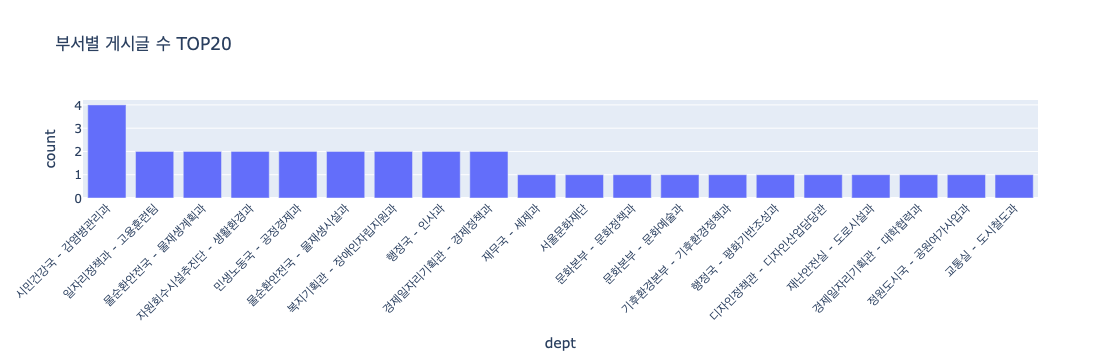

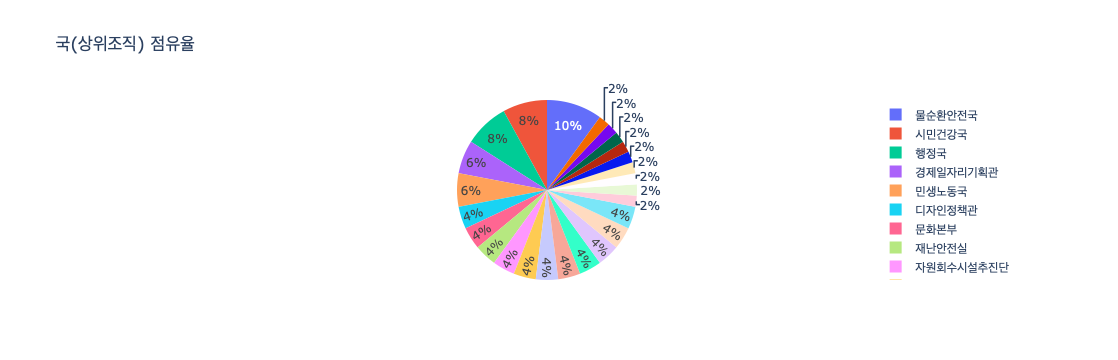

In [19]:
import pandas as pd
import plotly.express as px

dept_counts = df["dept"].value_counts().head(20).reset_index()
dept_counts.columns = ["dept", "count"]

fig = px.bar(dept_counts, x="dept", y="count", title="부서별 게시글 수 TOP20")
fig.update_layout(xaxis_tickangle=-45)
fig.show()

share = df["dept_group"].value_counts().reset_index()
share.columns = ["dept_group", "count"]
fig2 = px.pie(share, names="dept_group", values="count", title="국(상위조직) 점유율")
# fig2 = px.pie(share, values="count", title="국(상위조직) 점유율")
fig2.show()

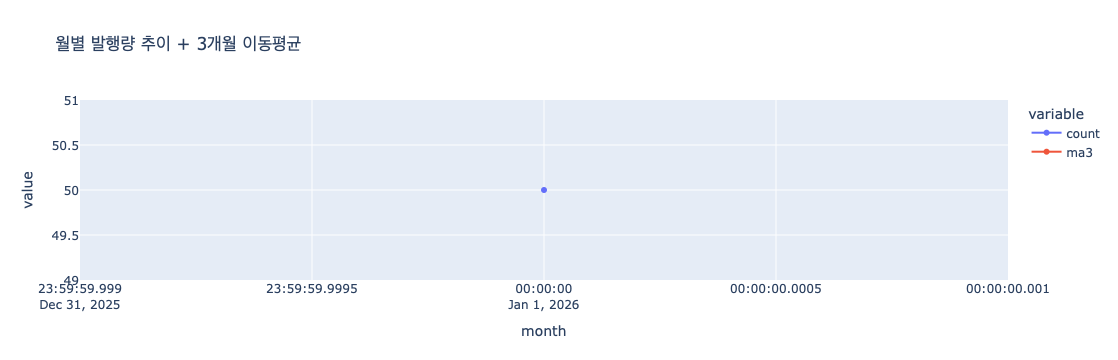

In [22]:
m = df.groupby("month").size().reset_index(name="count").sort_values("month")
m["ma3"] = m["count"].rolling(3).mean()

fig = px.line(m, x="month", y=["count", "ma3"], markers=True,
              title="월별 발행량 추이 + 3개월 이동평균")
fig.show()

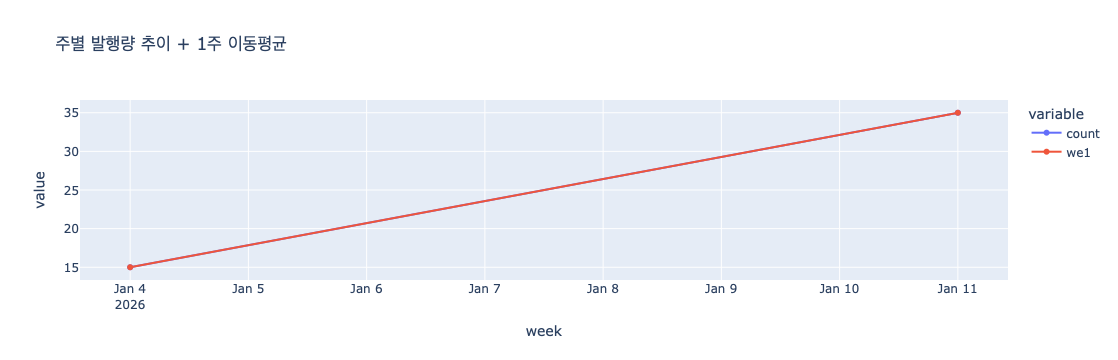

In [25]:
w = df.groupby("week").size().reset_index(name="count").sort_values("week")
w["we1"] = w["count"].rolling(1).mean()

fig = px.line(w, x="week", y=["count", "we1"], markers=True,
              title="주별 발행량 추이 + 1주 이동평균")
fig.show()

In [33]:
# pivot = (df.groupby(["dept_group","month"]).size())
pivot = (df.groupby(["dept_group","month"]).size().reset_index(name="count"))

pivot

dept_group      month  count
0     건설기술정책관 2026-01-01      1
1    경제일자리기획관 2026-01-01      3
2         교통실 2026-01-01      1
3      기후환경본부 2026-01-01      2
4      도시공간본부 2026-01-01      1
5      디자인정책관 2026-01-01      2
6      디지털도시국 2026-01-01      2
7        문화본부 2026-01-01      2
8      물순환안전국 2026-01-01      5
9       민생노동국 2026-01-01      3
10      복지기획관 2026-01-01      2
11   서부공원여가센터 2026-01-01      1
12     서울문화재단 2026-01-01      1
13      시민건강국 2026-01-01      4
14     일자리정책과 2026-01-01      2
15  자원회수시설추진단 2026-01-01      2
16      재난안전실 2026-01-01      2
17        재무국 2026-01-01      2
18      재정기획관 2026-01-01      2
19      정원도시국 2026-01-01      1
20    창조산업기획관 2026-01-01      1
21      첨단산업과 2026-01-01      1
22      평생교육국 2026-01-01      1
23        행정국 2026-01-01      4
24      홍보기획관 2026-01-01      2

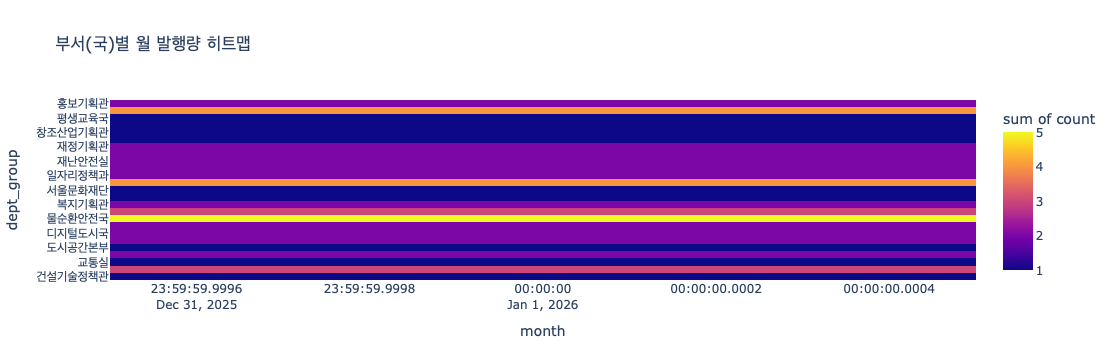

In [5]:
pivot = (df.groupby(["dept_group","month"]).size()
           .reset_index(name="count"))
fig = px.density_heatmap(pivot, x="month", y="dept_group", z="count",
                         title="부서(국)별 월 발행량 히트맵")
fig.show()

In [3]:
# pivot = (df.groupby(["dept_group","month"]).size())
pivot = (df.groupby(["dept_group","week"]).size().reset_index(name="count"))

pivot

dept_group       week  count
0     건설기술정책관 2026-01-11      1
1    경제일자리기획관 2026-01-04      1
2    경제일자리기획관 2026-01-11      2
3         교통실 2026-01-04      1
4      기후환경본부 2026-01-11      2
5      도시공간본부 2026-01-11      1
6      디자인정책관 2026-01-04      1
7      디자인정책관 2026-01-11      1
8      디지털도시국 2026-01-11      2
9        문화본부 2026-01-04      2
10     물순환안전국 2026-01-04      1
11     물순환안전국 2026-01-11      4
12      민생노동국 2026-01-04      1
13      민생노동국 2026-01-11      2
14      복지기획관 2026-01-11      2
15   서부공원여가센터 2026-01-11      1
16     서울문화재단 2026-01-04      1
17      시민건강국 2026-01-04      3
18      시민건강국 2026-01-11      1
19     일자리정책과 2026-01-04      1
20     일자리정책과 2026-01-11      1
21  자원회수시설추진단 2026-01-04      1
22  자원회수시설추진단 2026-01-11      1
23      재난안전실 2026-01-04      1
24      재난안전실 2026-01-11      1
25        재무국 2026-01-04      1
26        재무국 2026-01-11      1
27      재정기획관 2026-01-11      2
28      정원도시국 2026-01-11      1
29    창조산업기획관 2026-01-11      1
30      첨단산업과 2026-01-11      1
31      평생교육국 2026-01-11      1
32        행정국 2026-01-11      4
33      홍보기획관 2026-01-11      2

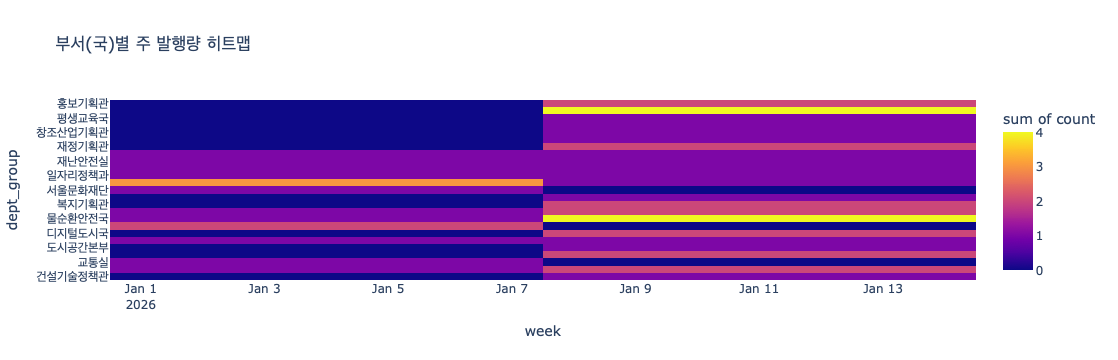

In [4]:
pivot = (df.groupby(["dept_group","week"]).size()
           .reset_index(name="count"))
fig = px.density_heatmap(pivot, x="week", y="dept_group", z="count",
                         title="부서(국)별 주 발행량 히트맵")
fig.show()

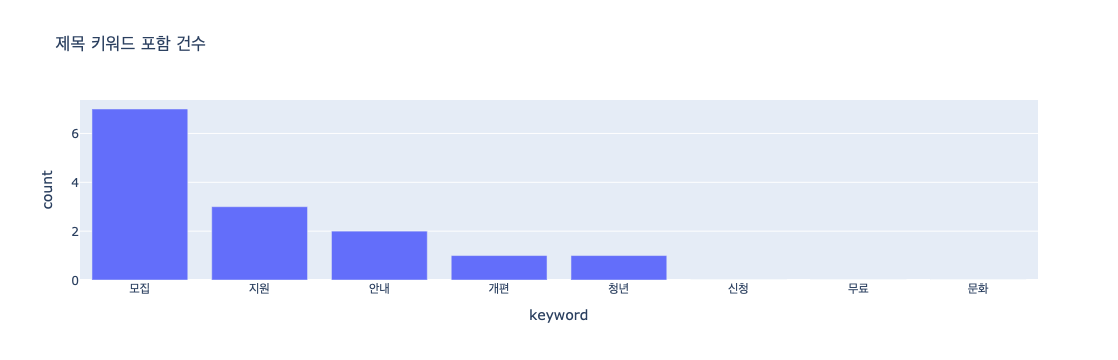

In [34]:
keywords = ["지원", "모집", "개편", "안내", "신청", "무료", "청년", "문화"]
rows = []
for kw in keywords:
    rows.append({"keyword": kw, "count": df["title"].str.contains(kw, na=False).sum()})
kdf = pd.DataFrame(rows).sort_values("count", ascending=False)

fig = px.bar(kdf, x="keyword", y="count", title="제목 키워드 포함 건수")
fig.show()

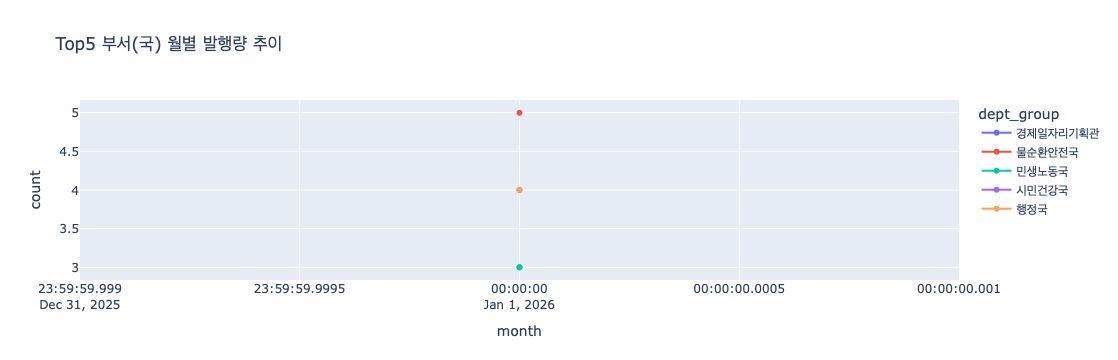

In [7]:
top_depts = df["dept_group"].value_counts().head(5).index.tolist()
d2 = df[df["dept_group"].isin(top_depts)]
trend = d2.groupby(["month","dept_group"]).size().reset_index(name="count")
fig = px.line(trend, x="month", y="count", color="dept_group", markers=True,
              title="Top5 부서(국) 월별 발행량 추이")
fig.show()

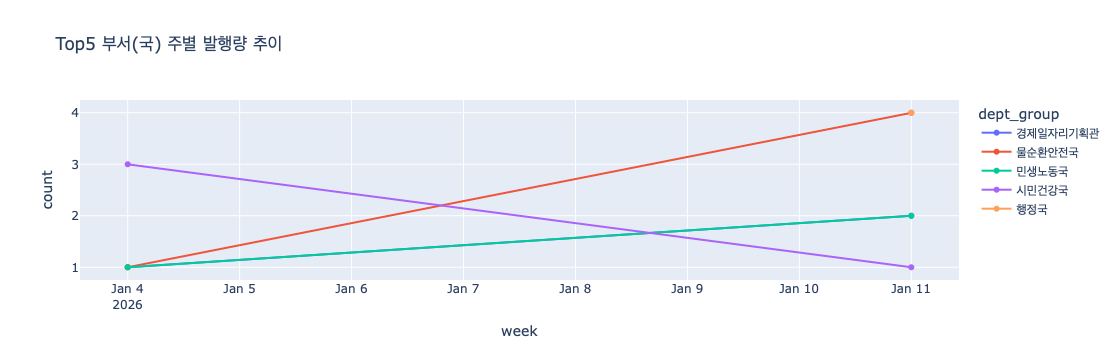

In [5]:
top_depts = df["dept_group"].value_counts().head(5).index.tolist()
w1 = df[df["dept_group"].isin(top_depts)]
trend = w1.groupby(["week","dept_group"]).size().reset_index(name="count")
fig = px.line(trend, x="week", y="count", color="dept_group", markers=True,
              title="Top5 부서(국) 주별 발행량 추이")
fig.show()

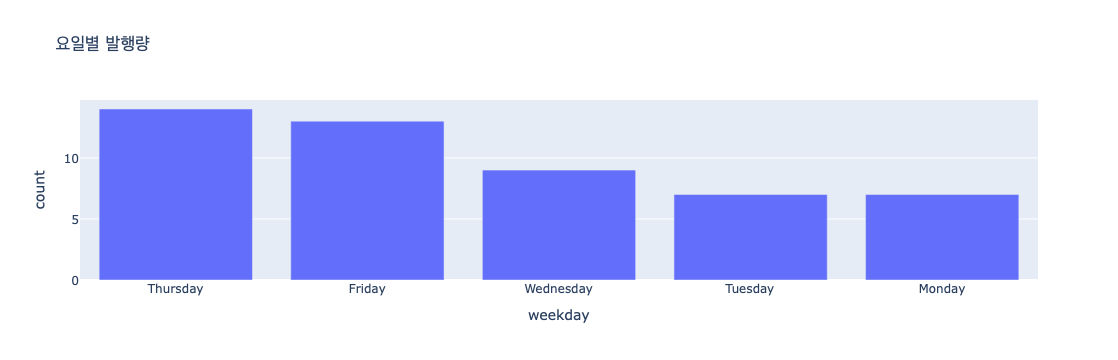

In [8]:
df["weekday"] = df["modified_date"].dt.day_name()
w = df["weekday"].value_counts().reset_index()
w.columns = ["weekday", "count"]
fig = px.bar(w, x="weekday", y="count", title="요일별 발행량")
fig.show()

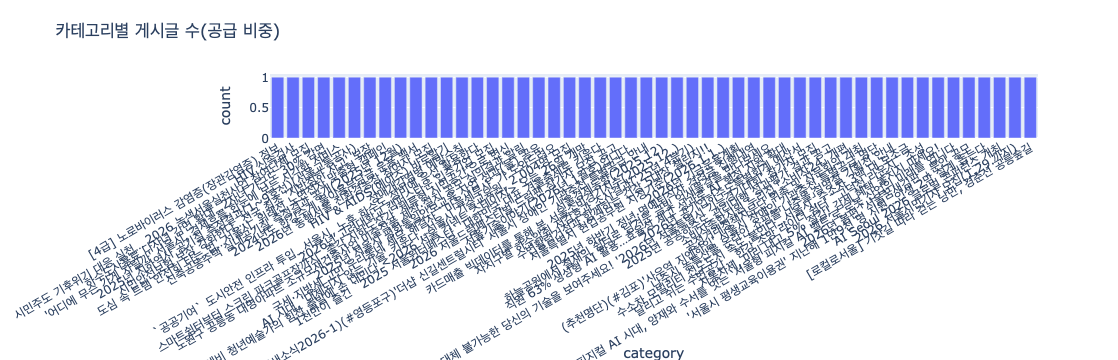

In [7]:
import pandas as pd
import plotly.express as px

df = pd.read_csv("seoul_news_p1_to_p5_with_dept_date.csv")
df["modified_date"] = pd.to_datetime(df["modified_date"], errors="coerce")
df = df.dropna(subset=["modified_date"])
df["month"] = df["modified_date"].dt.to_period("M").dt.to_timestamp()

# category가 없으면 title 기반으로 규칙 분류를 먼저 해도 됨
cat = df["title"].value_counts().reset_index()
cat.columns = ["category", "count"]

fig = px.bar(cat, x="category", y="count", title="카테고리별 게시글 수(공급 비중)")
fig.update_layout(xaxis_tickangle=-30)
fig.show()